# Reference

This code is based on [A Quantum Algorithm for the Bottleneck Travelling Salesman Problem](https://open.library.ubc.ca/soa/cIRcle/collections/undergraduateresearch/52966/items/1.0442410)


# Initial Set Up

## Prerequisites

> `Conda` is used as the tool for managing virtual environments

> `pip` is the package manager

> Please ensure that the gcc is installed. There are different approaches to install gcc on our windows, mac or linux servers. Identify a suitable guidance from internet search & install gcc on your work machine. The `matplotlib` library install shall fail due to missing gcc library.

## Steps to manage virtual environment & installing packages

1. Create a python virtual environment `qc-project-btsp` with `Python v3.11`

    ```
    conda create --name qc-project-btsp python=3.11
    ```

2. Activate the virtual environment 
    ```
    conda activate qc-project-btsp
    ```

3. Use `pip` to install the required packages
    ```
    conda activate qc-project-btsp
    pip install qiskit
    pip install qiskit_aer
    pip install matplotlib
    pip install pandas
    pip install pylatexenc
    pip install itertools
    pip install re
    ```

4. Create a directory `plots` in the same location where the notebook is placed in your work machine. The code generates results in pdf & would be saved in this directory

5. Install `Jyupter Notebook` & launch the notebook in Jyupter Notebook & start executing the code

# Algorithm

The decision problem of the BTSP seeks to determine if there exists a Hamiltonian cycle where the weight of each edge is less than a specified threshold α. In such a cycle, if we denote the
weight of any edge as γi, then it must satisfy the condition:

`γi < α`

Algorithm follows the below steps:
1. Normalize edge weights to ensure that no single Hamiltonian cycle’s total weight is greater
than or equal to 1, allowing for effective use of the phase estimation algorithm.
2. Construct a unitary operator that encodes information about the Hamiltonian cycles, representing these as phases along its diagonal. 
3. Set all edge weights ≥ α to zero and construct a secondary unitary operator similar to the one described in Step 2.
4. Create controlled gates using the unitary operators constructed in Step 2 and 3.
5. Identify all the eigenstates of the unitary operators that map to the phases associated with the Hamiltonian cycles.
6. Perform phase estimation twice, using the same eigenstate and controlled gates, to evaluate the Hamiltonian cycle both before and after setting edge weights ≥ α to zero.
7. Compare the two resulting phases; if they match, the Hamiltonian cycle under examination satisfies the condition and is a viable solution.

# Importing the libraries
> The below code was slightly modified to include some of the additional modules required to explain the theory

In [31]:
import numpy as np
from matplotlib import pyplot as plt
import math
# for circuit construction
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
# QFT circuit needed for phase estimation
from qiskit.circuit.library import QFT
# for creating custom gates
from qiskit import quantum_info as qi
# for simulation
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import plot_histogram
# for storing data later
import pandas as pd
import itertools
import re

# Undirected 4-City Graph
Let us consider the following example of a symmetric 4-city system. 

![4-City Symmetric Graph](./images/directedgraph.jpg)

_**For the below explanation, the representation of Hamitonian Cycles ignores the last city which would be same as the first city. i.e. the below representation of ABCD should be considered as hamitonian cycle - ABCDA**_

> What are the possible permutations of selecting N cities in different order from a list of N cities?

>> `P(N,N)=N!`

>>> For a four city graph with cities A, B , C & D, this comes out to be 4! records which is 24 as listed below

```
        ABCD
        ABDC
        ACBD
        ACDB
        ADBC
        ADCB
        BACD
        BADC
        BCAD
        BCDA
        BDAC
        BDCA
        CABD
        CADB
        CBAD
        CBDA
        CDAB
        CDBA
        DABC
        DACB
        DBAC
        DBCA
        DCAB
        DCBA
```

> What is the number of permutations if cyclic nature of the graph is considered?

>> Permutations would come down to `(N-1)!`

>>> For a four city graph with cities A, B , C & D, this would mean that ABCD is same BCDA and ACDB is same as CDBA etc. The records now reduces to 6 as shown below

```
    A B C D
    A B D C
    A C B D
    A C D B
    A D B C
    A D C B
```

> What happens when the symmetric nature of the records are considered?

>> Because of the symmetric nature of the graph, the costs are same for a sequence and its reverse record. The number of unique arrangements when both rotation and reversal are considered equivalent is: `(N-1)!2`

>>> For a four city graph with cities A, B , C & D, this would mean that the solution space shrinks to 3 entries
```
    A B C D (same as D C B A)
    A B D C (same as C D B A)
    A C B D (same as D B C A)
```

Applying Bottle Neck TSPB
The condition for our BTSP in this case will involve finding a Hamiltonian cycle where all edge weights are < 6
Here 6 is an arbitary value, it could have been something else as well, greater than or less than 6.

# Encoding of the Hamiltonian Routes

A hamiltonian route is a combination of 4 cities such that 
- every city is included at least once
- only one city is repeated twice in the cycle, because the cycle ends at first city

Thsi means every hamiltonian cycle in a 4 city graph will have 5 elements

> Route: A->B->C->D
>> Let us now represent this slightly differently as a list of 4 edge. The representation edge have a character and number  such that the characters a, b, c, d represent the 4 cities A, B, C, D & again the numbers 0,1,2,3 represent the cities A, B, C, D. Thus the route A->B->C->D can be represented as a1, b2, c3, d0 (a1b2c3d0) which same as representing the edges A-B, B-C, C-D, D-A. Now we will have to order the edges alphabetically - which in this case is same as a1, b2, c3, d0. Remove the alphabets whcih leaves us with 1, 2, 3, 0. Represent each number in binary format which will make it as 01101100 & the equivalent representation in decimal base would be 108

> Route: A->B->D->C
>> Edges would be a1, b3, d2, c0 which sorted alphabetically shall give (a1b3c0d2) & removing the alphabets leaves it as 1302 binary representation would be 01110010 & decimal representation would be 114

> Route: A->C->B->D
>> Edges would be a2, c1, b3, d0 which sorted alphabetically shall give (a2b3c1d0) & removing the alphabets leaves it as 2310, binary representation would be 10110100 & decimal representation would be 180


# Intention of the Unitary Matrix

The Unitary matrix we are intending to build should take the eigen vectors corresponding to the hamitonian cycles and provide an output which shifts the phase by the cost of the hamiltonain cycle.

Hypothetically, the full set of inputs that can be provided to this Unitary matrix would be 

> 4<sup>4</sup> 

or in general if there are N cities then it should take N<sup>N</sup> inputs

Let us start building the Unitary Matrix

# Representing the weights in a set of matrices

Let us start with 4 matrices each corresponding to 4 cities. 
Let us call these matrices A, B, C & D
The matrix A provides the weight from A->A, A->B, A->C & A->D in its diagonal elements
The below code generates and prints 4 such matrix

> This code has been newly added to explain the representation of weights as a set of matrices

In [32]:
def create_diagonal_matrix(diagonal_values):
    return np.diag(diagonal_values)

# Define diagonal values for each matrix
A = np.array(["e^ia0.", "e^ia1.", "e^ia2.", "e^ia3."])
B = np.array(["e^ib0.", "e^ib1.", "e^ib2.", "e^ib3."])
C = np.array(["e^ic0.", "e^ic1.", "e^ic2.", "e^ic3."])
D = np.array(["e^id0.", "e^id1.", "e^id2.", "e^id3."])

# Create diagonal matrices
A_matrix = create_diagonal_matrix(A)
B_matrix = create_diagonal_matrix(B)
C_matrix = create_diagonal_matrix(C)
D_matrix = create_diagonal_matrix(D)

# Print matrices
print("Matrix A:")
print(A_matrix)
print("\nMatrix B:")
print(B_matrix)
print("\nMatrix C:")
print(C_matrix)
print("\nMatrix D:")
print(D_matrix)

Matrix A:
[['e^ia0.' '' '' '']
 ['' 'e^ia1.' '' '']
 ['' '' 'e^ia2.' '']
 ['' '' '' 'e^ia3.']]

Matrix B:
[['e^ib0.' '' '' '']
 ['' 'e^ib1.' '' '']
 ['' '' 'e^ib2.' '']
 ['' '' '' 'e^ib3.']]

Matrix C:
[['e^ic0.' '' '' '']
 ['' 'e^ic1.' '' '']
 ['' '' 'e^ic2.' '']
 ['' '' '' 'e^ic3.']]

Matrix D:
[['e^id0.' '' '' '']
 ['' 'e^id1.' '' '']
 ['' '' 'e^id2.' '']
 ['' '' '' 'e^id3.']]


# Unitary Matrix

Using the above defined matrices, let us build the unitary matrix, which would be

`U = A ⊗ B ⊗ C ⊗ D`

Since all the matrices A, B, C & D are diagonal matrices, thier tensor products shall also be diagonal matrices

The below code prints diagonal matrices along with the row & column values (which should be same value for a given row), the binary representation of the hamiltonian encoded route, the decimal representation of the hamiltonian encided route & the actual cost of the hamiltonian route, which is same as the corresponding value in the diagonal matrix

> The below code was newly added to generte and print the Unitary matix


In [33]:
# Define symbolic diagonal matrices
# A = np.array(["e^ia0.", "e^ia1.", "e^ia2.", "e^ia3."])
# B = np.array(["e^ib0.", "e^ib1.", "e^ib2.", "e^ib3."])
# C = np.array(["e^ic0.", "e^ic2.", "e^ic2.", "e^ic3."])
# D = np.array(["e^id0.", "e^id1.", "e^id2.", "e^id3."])

# Compute Kronecker Product using string concatenation
U_diag = [a + b + c + d for a, b, c, d in itertools.product(A, B, C, D)]

# Extract only the numbers from each value while preserving order
U_diag_numbers = ["".join(re.findall(r"\d+", val)) for val in U_diag]

# Convert to a matrix with two columns: original value + extracted numbers
U = np.empty((256, 4), dtype=object)  # Create an empty array for row index, value, and extracted number
for idx, (val, num) in enumerate(zip(U_diag, U_diag_numbers)):
    U[idx] = [idx,(bin(idx)[2:]), num, val]  # Store row index, original value, and extracted numbers

# Print each row with position, value, and extracted numbers
print("Row | Column| Encoded Route | Decimal Representation of Encoded Route| Diagonal Element in Unitary Matrix")
for row in U:
    print(f"{row[0]} |{row[0]} | {row[1]} | {row[2]}| {row[3]}")

# Save to CSV
np.savetxt("kronecker_product_symbols_with_numbers.csv", U, delimiter=",", fmt="%s", header="Row,Value,Numbers", comments="")
print("Matrix saved as 'kronecker_product_symbols_with_numbers.csv'")


Row | Column| Encoded Route | Decimal Representation of Encoded Route| Diagonal Element in Unitary Matrix
0 |0 | 0 | 0000| e^ia0.e^ib0.e^ic0.e^id0.
1 |1 | 1 | 0001| e^ia0.e^ib0.e^ic0.e^id1.
2 |2 | 10 | 0002| e^ia0.e^ib0.e^ic0.e^id2.
3 |3 | 11 | 0003| e^ia0.e^ib0.e^ic0.e^id3.
4 |4 | 100 | 0010| e^ia0.e^ib0.e^ic1.e^id0.
5 |5 | 101 | 0011| e^ia0.e^ib0.e^ic1.e^id1.
6 |6 | 110 | 0012| e^ia0.e^ib0.e^ic1.e^id2.
7 |7 | 111 | 0013| e^ia0.e^ib0.e^ic1.e^id3.
8 |8 | 1000 | 0020| e^ia0.e^ib0.e^ic2.e^id0.
9 |9 | 1001 | 0021| e^ia0.e^ib0.e^ic2.e^id1.
10 |10 | 1010 | 0022| e^ia0.e^ib0.e^ic2.e^id2.
11 |11 | 1011 | 0023| e^ia0.e^ib0.e^ic2.e^id3.
12 |12 | 1100 | 0030| e^ia0.e^ib0.e^ic3.e^id0.
13 |13 | 1101 | 0031| e^ia0.e^ib0.e^ic3.e^id1.
14 |14 | 1110 | 0032| e^ia0.e^ib0.e^ic3.e^id2.
15 |15 | 1111 | 0033| e^ia0.e^ib0.e^ic3.e^id3.
16 |16 | 10000 | 0100| e^ia0.e^ib1.e^ic0.e^id0.
17 |17 | 10001 | 0101| e^ia0.e^ib1.e^ic0.e^id1.
18 |18 | 10010 | 0102| e^ia0.e^ib1.e^ic0.e^id2.
19 |19 | 10011 | 0103| e^ia0.e^i

# Applying the Unitary Gate on Eigen Vector

The eigen vectors of interest to us are corresponding to these hamiltonian cycles
## Route: A->B->C->D
> a1b2c3d0 --- 1230 --- 01101100 --- 108

> When represented as a column vector, this would [0, 0 .... 1... 0]. The one will be at 108th position (index at 0)

> When the Unitary vector U is applied, the corresponding phase that would be applied would be - [a1+b2+c3+d0]

## Route: A->B->D->C
> a1b3c0d2 --- 1302 --- 01110010 --- 114

> When represented as a column vector, this would [0, 0 .... 1... 0]. The one will be at 114th position (index at 0)

> When the Unitary vector U is applied, the corresponding phase that would be applied would be - [a1+b3+c0+d2]

## Route: A->C->B->D
> a2b3c1d0 --- 2310 --- 10110100 --- 180

> When represented as a column vector, this would [0, 0 .... 1... 0]. The one will be at 180th position (index at 0)

> When the Unitary vector U is applied, the corresponding phase that would be applied would be - [a2+b3+c1+d0]

This clearly shows that the phase applied on the eigen vector will be the cost of the hamiltonian cycle & the eigen value is e<sup>i.Cost_Of_The_Hamiltonian_Cycle</sup> 

# Controlled Unitary Gate

Since the phase cannot be measured directly using the basis gates, the QPE approach need to be used. This would mean the the unitary matrix/ gate should be converted into a controlled unitary gate

Use the unitary matrix/ gate U to a controlled gate by applying the following principle

![Controlled Unitary Graph](./images/ControlledUnitaryGate.jpg)

> The below code was newly added to generate the output of the diagonal elements of controlled unitary matrix

In [34]:
print("ControlBit/Row | Diagonal Element in Unitary Matrix")

for row in U:
    print(f"0/{row[0]} | 1")

for row in U:
    print(f"1/{row[0]} | {row[3]}")

ControlBit/Row | Diagonal Element in Unitary Matrix
0/0 | 1
0/1 | 1
0/2 | 1
0/3 | 1
0/4 | 1
0/5 | 1
0/6 | 1
0/7 | 1
0/8 | 1
0/9 | 1
0/10 | 1
0/11 | 1
0/12 | 1
0/13 | 1
0/14 | 1
0/15 | 1
0/16 | 1
0/17 | 1
0/18 | 1
0/19 | 1
0/20 | 1
0/21 | 1
0/22 | 1
0/23 | 1
0/24 | 1
0/25 | 1
0/26 | 1
0/27 | 1
0/28 | 1
0/29 | 1
0/30 | 1
0/31 | 1
0/32 | 1
0/33 | 1
0/34 | 1
0/35 | 1
0/36 | 1
0/37 | 1
0/38 | 1
0/39 | 1
0/40 | 1
0/41 | 1
0/42 | 1
0/43 | 1
0/44 | 1
0/45 | 1
0/46 | 1
0/47 | 1
0/48 | 1
0/49 | 1
0/50 | 1
0/51 | 1
0/52 | 1
0/53 | 1
0/54 | 1
0/55 | 1
0/56 | 1
0/57 | 1
0/58 | 1
0/59 | 1
0/60 | 1
0/61 | 1
0/62 | 1
0/63 | 1
0/64 | 1
0/65 | 1
0/66 | 1
0/67 | 1
0/68 | 1
0/69 | 1
0/70 | 1
0/71 | 1
0/72 | 1
0/73 | 1
0/74 | 1
0/75 | 1
0/76 | 1
0/77 | 1
0/78 | 1
0/79 | 1
0/80 | 1
0/81 | 1
0/82 | 1
0/83 | 1
0/84 | 1
0/85 | 1
0/86 | 1
0/87 | 1
0/88 | 1
0/89 | 1
0/90 | 1
0/91 | 1
0/92 | 1
0/93 | 1
0/94 | 1
0/95 | 1
0/96 | 1
0/97 | 1
0/98 | 1
0/99 | 1
0/100 | 1
0/101 | 1
0/102 | 1
0/103 | 1
0/104 | 1
0/105 | 

In [35]:
#4-city graph edge weights as described in chapter 4.1
w_1 = 4 # a <-> b
w_2 = 2 # a <-> c
w_3 = 4 # a <-> d
w_4 = 4 # b <-> c
w_5 = 5 # c <-> d
w_6 = 6 # b <-> d


# Normalizing the weights

Steps to normalize:

1. Sort the edge weights in descending order
2. Retrive the sum S of the largest N items. N is the number of cities in the graph (4 in opur case) 
> Relevance of this sum S - there cannot be any Hamiltonian cycle whose total code is greater S
> This would mean that when the normalization is performed and the measurements are made, at no point would the measurement cross the value of 1, thus ensuring that the phase estimation approach can be used. (The phase value should remain within 2pi for the QPE algorithm to work)
3. Determine the denominator for normalizing the weight
> It would be S + eps. 
> The value of eps is considered as 1. 
> When S is very large the impact of eps will be insignificant
> However addition of eps can help us ensure that the demonimator is never 0
> There could be other benefits of adding a 1, which we are not sure of at this point
4. Apply the normalization across all weights

> The below code was slightly modified to include more print statements

In [36]:
weights = []
for i in range(1, 7):
    variable_name = "w_" + str(i)
    current_number = locals()[variable_name]
    weights.append(current_number)
#sorting edge weights
sorted_weights = np.sort(weights)[::-1]
print("Sorted Weights:")
print(sorted_weights)
print("Top 4 Weights:")
print(sorted_weights[:4])
# normalization factor
S = np.sum(sorted_weights[:4])
print("Sum of top 4 Weights:")
print(S)
# epsilon
eps = 1
print("Normalization Demoninator:")
print((S + eps))
weights = weights / (S + eps)
print("Normalized Weights:")
weights

Sorted Weights:
[6 5 4 4 4 2]
Top 4 Weights:
[6 5 4 4]
Sum of top 4 Weights:
19
Normalization Demoninator:
20
Normalized Weights:


array([0.2 , 0.1 , 0.2 , 0.2 , 0.25, 0.3 ])

# Removing the max weight 


In [37]:
## solutions
# A->B->C->D->A
# A->B->D->C->A
# A->C->B->D->A
print('solution 1: {:.2f}'.format(weights[0] + weights[3] + weights[4] + weights[2]))
print('solution 2: {}'.format(weights[0] + weights[5] + weights[4] + weights[1]))
print('solution 3: {}'.format(weights[1] + weights[3] + weights[5] + weights[2]))
print(" ")
print('solutions after max weight removed')
print('solution 1: {:.2f}'.format(weights[0] + weights[3] + weights[4] + weights[2]))
print('solution 2: {}'.format(weights[0] + weights[4] + weights[1]))
print('solution 3: {}'.format(weights[1] + weights[3] + weights[2]))

solution 1: 0.85
solution 2: 0.85
solution 3: 0.8
 
solutions after max weight removed
solution 1: 0.85
solution 2: 0.55
solution 3: 0.5


# Creating CU matrix

> Code below was slightly modified to save the U as a matrix.csv

In [38]:
## Creating CU matrix
m = 8 # eigenvalue qubits
U111 = 1
U122 = np.exp(1j * weights[0] * 2 * np.pi)
U133 = np.exp(1j * weights[1] * 2 * np.pi)
U144 = np.exp(1j * weights[2] * 2 * np.pi)
U1 = np.diag([U111, U122, U133, U144])
U211 = np.exp(1j * weights[0] * 2 * np.pi)
U222 = 1
U233 = np.exp(1j * weights[3] * 2 * np.pi)
U244 = np.exp(1j * weights[5] * 2 * np.pi)
U2 = np.diag([U211, U222, U233, U244])
U311 = np.exp(1j * weights[1] * 2 * np.pi)
U322 = np.exp(1j * weights[3] * 2 * np.pi)
U333 = 1
U344 = np.exp(1j * weights[4] * 2 * np.pi)
U3 = np.diag([U311, U322, U333, U344])
U411 = np.exp(1j * weights[2] * 2 * np.pi)
U422 = np.exp(1j * weights[5] * 2 * np.pi)
U433 = np.exp(1j * weights[4] * 2 * np.pi)
U444 = 1
U4 = np.diag([U411, U422, U433, U444])
U = np.kron(np.kron(np.kron(U1,U2),U3),U4)
U = np.kron(np.kron(np.kron(U1,U2),U3),U4)
df = pd.DataFrame(U)  # Convert NumPy array to DataFrame
df.to_csv("matrix.csv", index=False, header=False, float_format="%.4f")  # Save without row/column labels
print(np.all(np.diag(U) != 0)) # confirming only the diagonal is being used.
Ugate = qi.Operator(U).to_instruction()
Ugate.label = "CU"
CUgate = Ugate.control()

True


# Defining a list of Eigen States

In [39]:
## confirming the eigenstates are correct
eigstatelist = ['01101100', #1230 A->B->C->D->A
'01110010', #1302 A->B->D->C->A
'10110100'] #2310 A->C->B->D->A
U_angles = np.diag(np.angle(U))/2/np.pi
eiglistint = [int(eigstatelist[i], 2) for i in range(len(eigstatelist))]
# converting from (-pi,pi) to (0,2pi)
sol_check = U_angles[eiglistint] + 1
sol_check

array([0.85, 0.85, 0.8 ])

# Creating Controlled Unitary for BTSP

This is achieved by making the edges of highest value with 0. (i.e. actual value 6 or normalized value 0.3 is replaced to 0)
This approach is based on some heuristics defined in 

> [3] John Larusic. A heuristic for solving the bottleneck traveling salesman problem. 2005.
> [4] Ravi Ramakrishnan, Prabha Sharma, and Abraham P. Punnen. An efficient heuristic algorithm for the bottleneck traveling salesman problem. Opsearch, 46(3):275–288, 09

It is assumed to be lower bound heurstics apporach. However, it is not clear how this works!!!

In [40]:
### creating CU'
## removing edge-weight value 6 (normalized val = 0.3)
max_index = np.where(weights == 0.3)[0][0]
weights[max_index] = 0
U111 = 1
U122 = np.exp(1j * weights[0] * 2 * np.pi)
U133 = np.exp(1j * weights[1] * 2 * np.pi)
U144 = np.exp(1j * weights[2] * 2 * np.pi)
U1 = np.diag([U111, U122, U133, U144])
U211 = np.exp(1j * weights[0] * 2 * np.pi)
U222 = 1
U233 = np.exp(1j * weights[3] * 2 * np.pi)
U244 = np.exp(1j * weights[5] * 2 * np.pi)
U2 = np.diag([U211, U222, U233, U244])
U311 = np.exp(1j * weights[1] * 2 * np.pi)
U322 = np.exp(1j * weights[3] * 2 * np.pi)
U333 = 1
U344 = np.exp(1j * weights[4] * 2 * np.pi)
U3 = np.diag([U311, U322, U333, U344])
U411 = np.exp(1j * weights[2] * 2 * np.pi)
U422 = np.exp(1j * weights[5] * 2 * np.pi)
U433 = np.exp(1j * weights[4] * 2 * np.pi)
U444 = 1
U4 = np.diag([U411, U422, U433, U444])
Up = np.kron(np.kron(np.kron(U1,U2),U3),U4)
print(np.all(np.diag(Up) != 0))# confirming only the diagonal is being used.
UPgate = qi.Operator(Up).to_instruction()
UPgate.label = "CU'"
CUPgate = UPgate.control()

True


# Some testing code

This need to be understood better

In [41]:
U_angles = np.diag(np.angle(Up))/2/np.pi
eiglistint = [int(eigstatelist[i], 2) for i in range(len(eigstatelist))]
# converting from (-pi,pi) to (0,2pi)
sol_check = U_angles[eiglistint] + 1
sol_check[2] -= 1
sol_check

array([0.85, 0.55, 0.5 ])

# Defining the circuit & supporting functions

In [42]:
def bitstring_converter(string):

    '''
    converts binary values < 1 to decimal
    specifically for the results retrieved
    from simulation
    '''
    values = []
    value = 0
    j = 0
    for i, v in enumerate(string):
        if v == '1':
            value += 1/(2**(i+1-j))
        elif v == " ":
            values.append(value)
            value = 0
            j = i+1
        if i == len(string)-1:
            values.append(value)
    return values[::-1]

def SingleHamiltonianCycle(eig, n):
    # we need a register for the eigenstate:
    eigst = QuantumRegister(m, name = 'eigenstate')
    # we need two registers for the constrained problem:
    phase = QuantumRegister(n, name = 'phase')
    phase_c = QuantumRegister(n, name = 'phase c')
    cr = ClassicalRegister(n, 'output')
    cr_c = ClassicalRegister(n, 'output c')
    # constructing the circuit (Initialization):
    qc = QuantumCircuit(phase, phase_c,eigst, cr,cr_c)
    # Apply H-Gates to phase qubits:
    for qubit in range(2*n):
        qc.h(qubit)
    for ind, val in enumerate(eig):
        if(int(val)):
            qc.x(ind + 2*n)
    ## Phase Estimation
    eig_qubits = np.arange(0,m) + 2*n
    repetitions = 1
    for counting_qubit in range(2*n):
        if counting_qubit == n:
            repetitions = 1
            qc.append(QFT(num_qubits = n, inverse = True, do_swaps=True), phase)
            qc.barrier()
        applied_qubits = np.append([counting_qubit], [eig_qubits])
        for i in range(repetitions):
            if counting_qubit < n:
                qc.append(CUgate, list(applied_qubits)); # This is CU
            else:
                qc.append(CUPgate, list(applied_qubits));
        repetitions *= 2
    qc.append(QFT(num_qubits = n, inverse = True, do_swaps=True), phase_c)
    qc.barrier()
    qc.measure(phase,cr)
    qc.measure(phase_c,cr_c)
    
    return qc

# Cycle 1 Circuit Creation

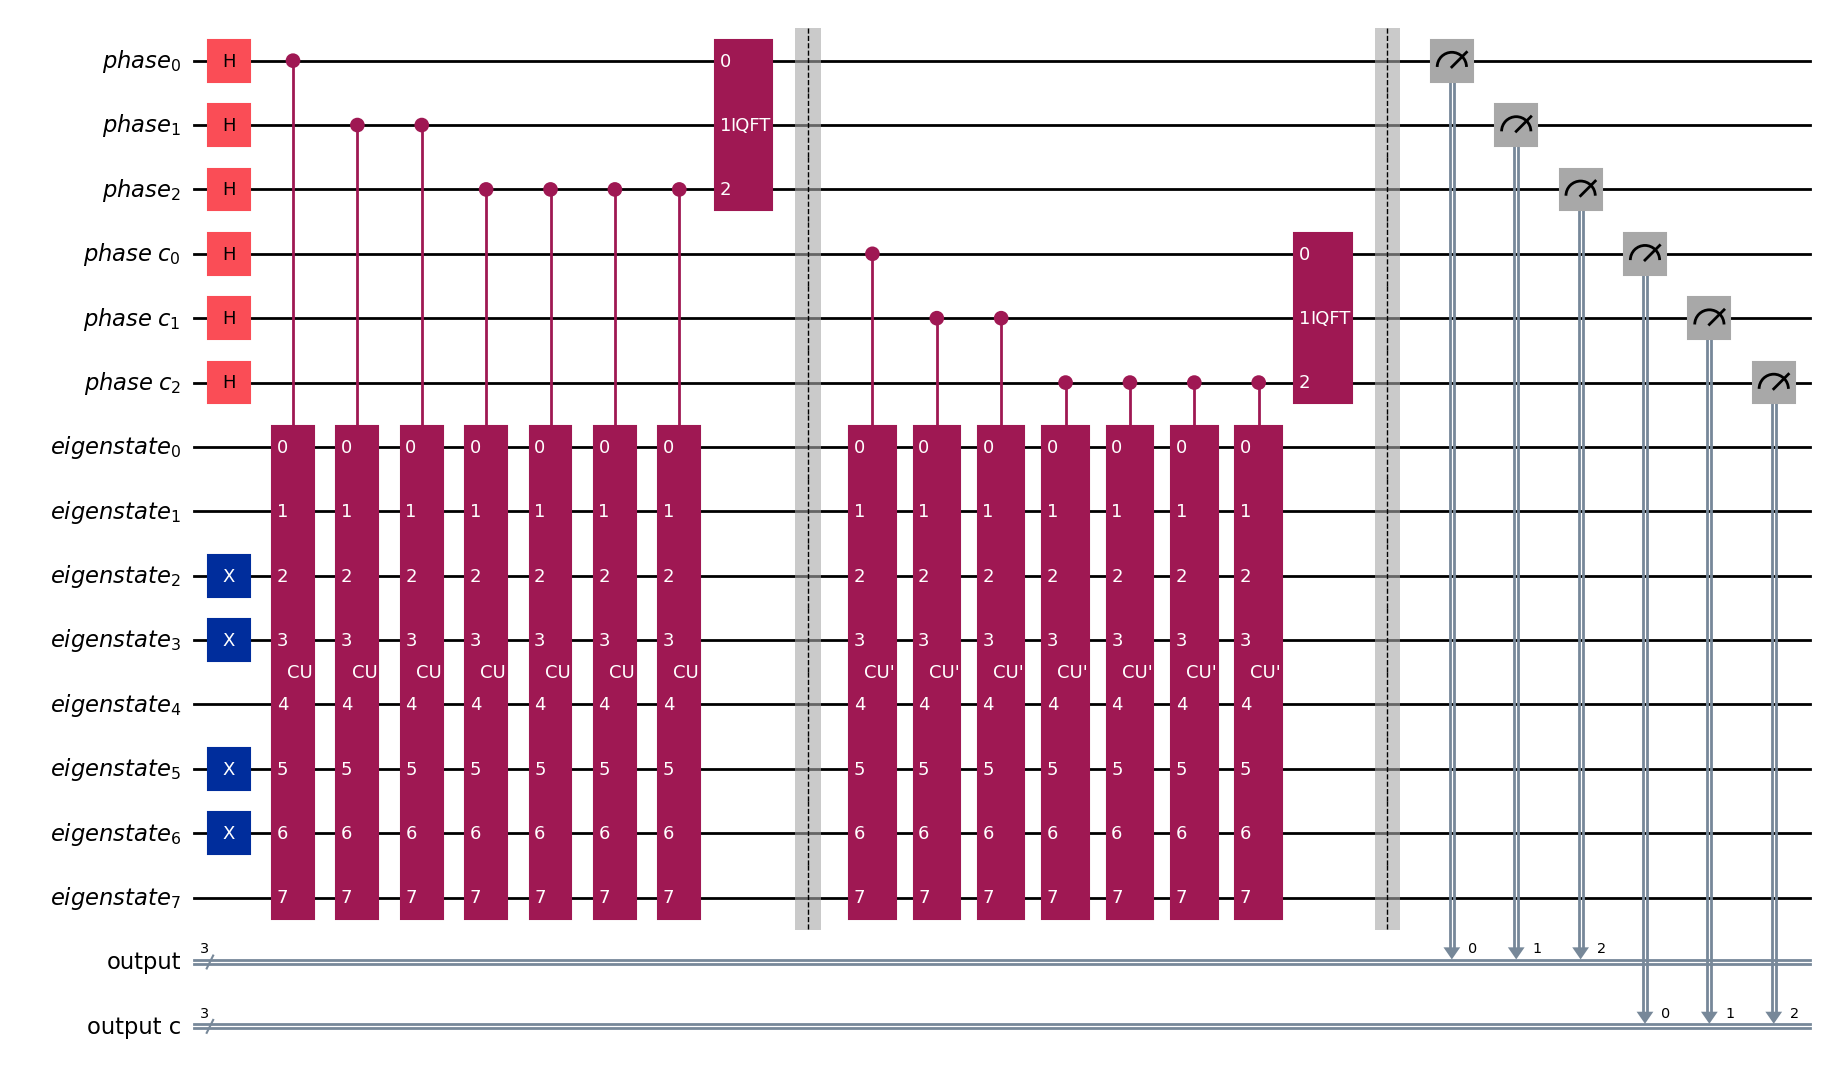

In [43]:
n = 3 ## number of estimation qubits.
## A->B->C->D->A
eig = eigstatelist[0]
eig = eig[::-1] # needs to be reversed (Qiskit convention)
qc1 = SingleHamiltonianCycle(eig, n)
qc1.draw(fold=-1, output='mpl')

# Cycle 1 Circuit Execution

In [44]:
simulator = Aer.get_backend('qasm_simulator')
qc1 = transpile(qc1, simulator)
result = simulator.run(qc1).result()
counts1 = result.get_counts(qc1)

# Cycle 2 Circuit Creation

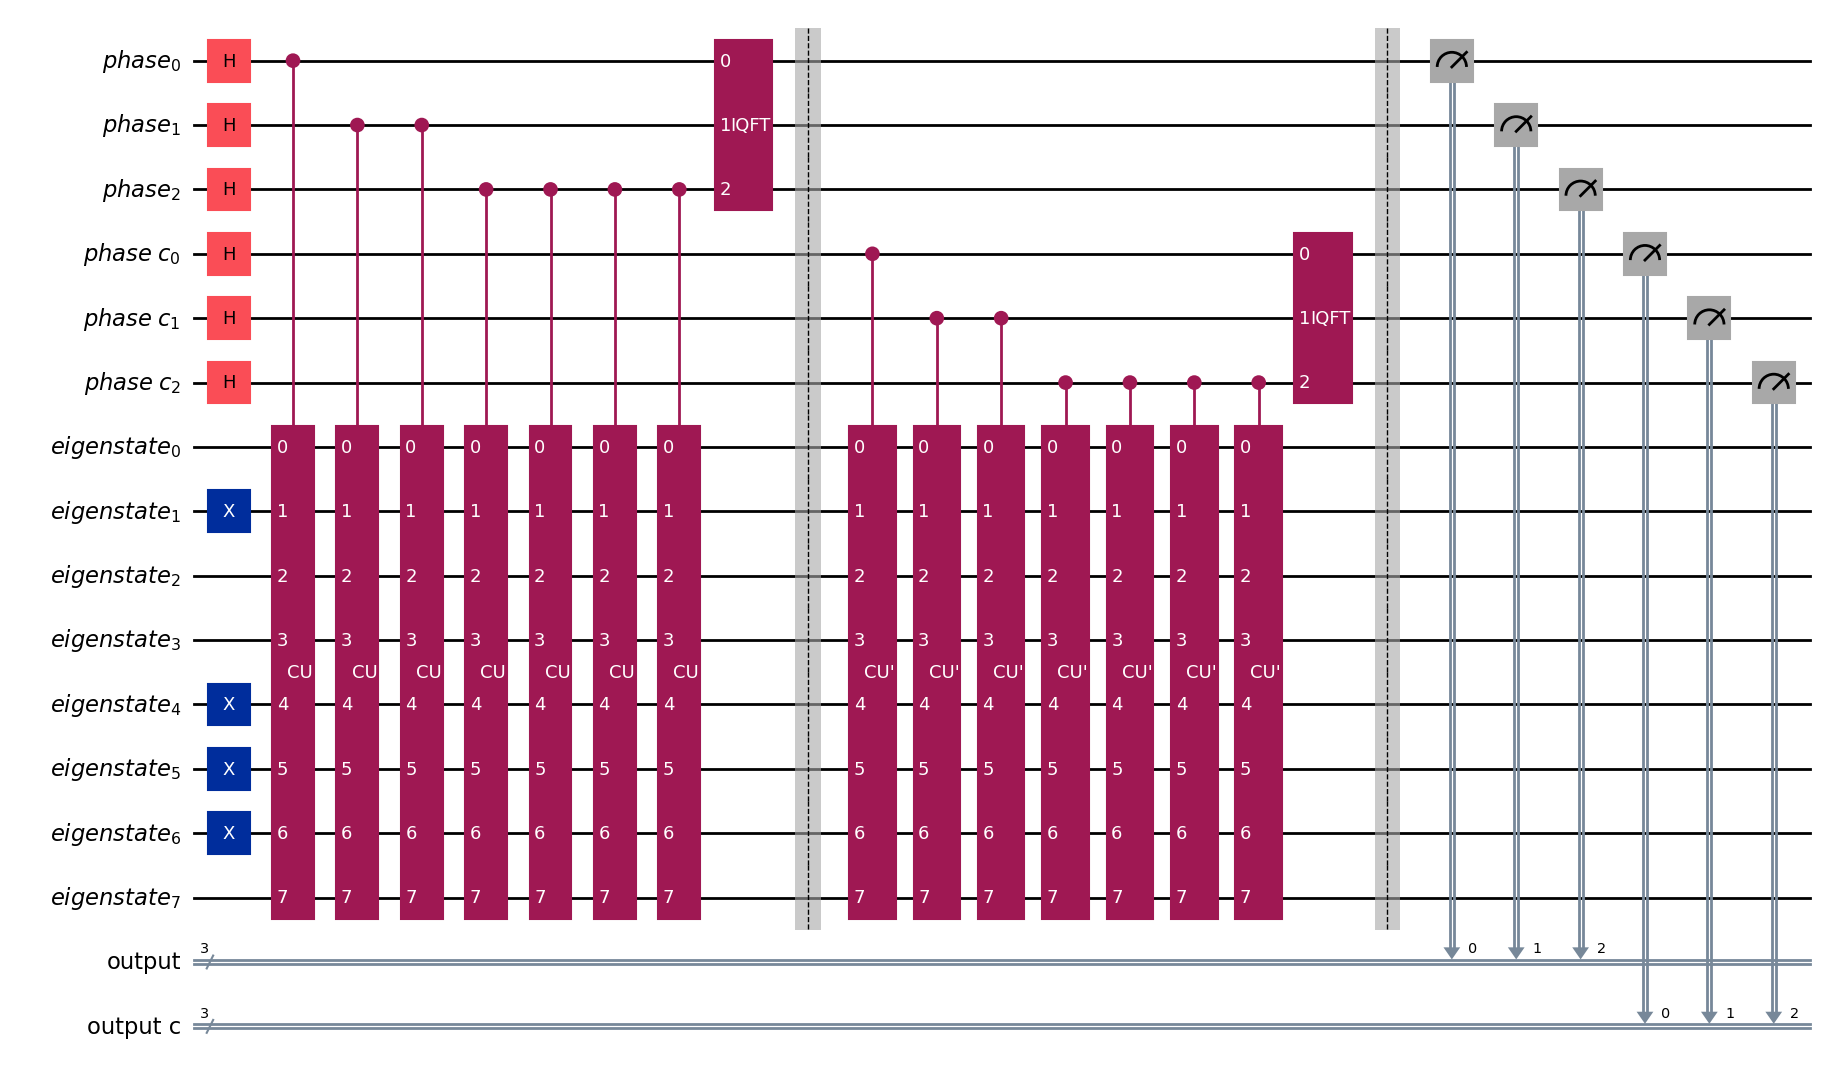

In [45]:
## A->B->D->C->A
eig = eigstatelist[1]
eig = eig[::-1] # needs to be reversed (Qiskit convention)
qc2 = SingleHamiltonianCycle(eig, n)
qc2.draw(fold=-1, output='mpl')

# Cycle 2 Circuit Execution

In [46]:
simulator = Aer.get_backend('qasm_simulator')
qc2 = transpile(qc2, simulator)
result = simulator.run(qc2).result()
counts2 = result.get_counts(qc2)

# Cycle 3 Creation

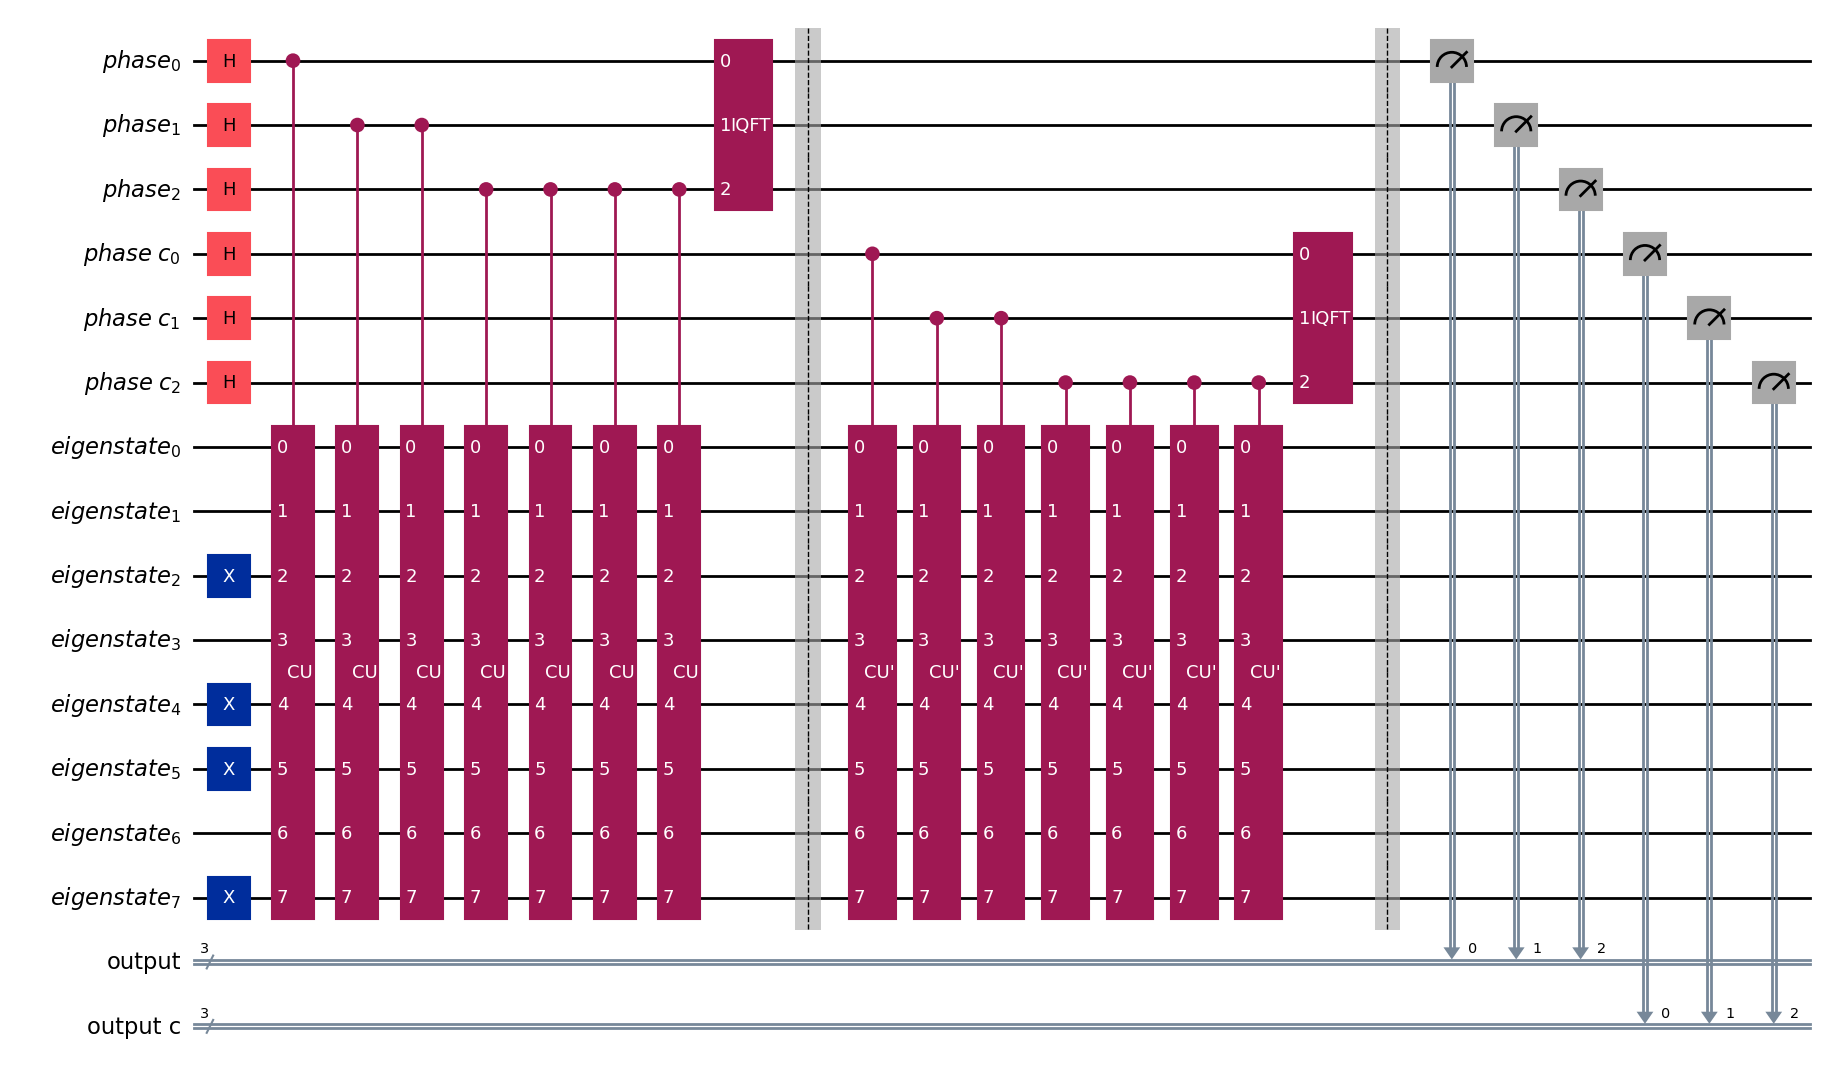

In [47]:
## A->C->B->D->A
eig = eigstatelist[2]
eig = eig[::-1] # needs to be reversed (Qiskit convention)
qc3 = SingleHamiltonianCycle(eig, n)
qc3.draw(fold=-1, output='mpl')

# Cycle 3 Execution

In [48]:
simulator = Aer.get_backend('qasm_simulator')
qc3 = transpile(qc3, simulator)
result = simulator.run(qc3).result()
counts3 = result.get_counts(qc3)

# Print Quick Results

In [49]:
# quick check
# printing most probable values [before, after] constraint values removed
print(' before after')
print('cycle 1', bitstring_converter(max(counts1, key=counts1.get)))
print('cycle 2', bitstring_converter(max(counts2, key=counts2.get)))
print('cycle 3', bitstring_converter(max(counts3, key=counts3.get)))

 before after
cycle 1 [0.875, 0.875]
cycle 2 [0.875, 0.5]
cycle 3 [0.75, 0.5]


# Print Detailed Results

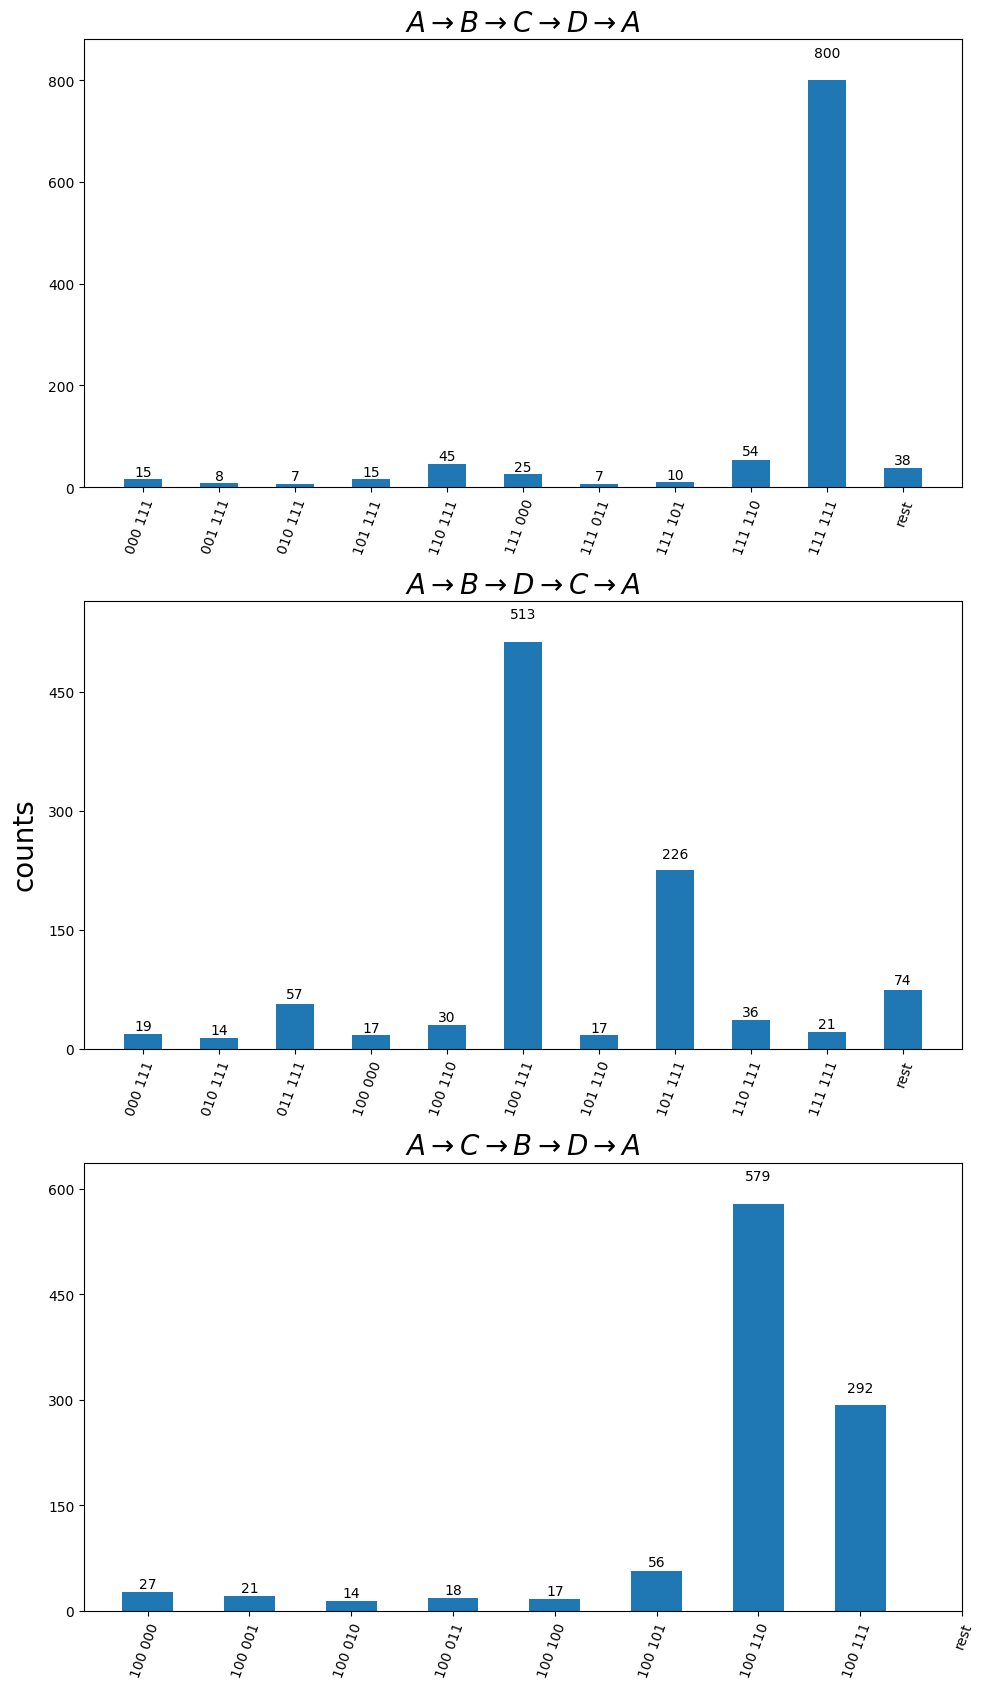

In [50]:
fig, ax = plt.subplots(3, 1, figsize=(10, 17))
fig.subplots_adjust(hspace=10)
fig.supylabel('counts', fontsize=20)
plot_histogram(counts1, number_to_keep = 10, ax= ax[0])
plot_histogram(counts2, number_to_keep = 10, ax = ax[1])
plot_histogram(counts3, number_to_keep = 10, ax = ax[2])
ax[0].set_title('$A \\rightarrow B \\rightarrow C \\rightarrow D \\rightarrow A$',fontsize = 20)
ax[1].set_title('$A \\rightarrow B \\rightarrow D \\rightarrow C \\rightarrow A$',fontsize = 20)
ax[2].set_title('$A \\rightarrow C \\rightarrow B \\rightarrow D \\rightarrow A$',fontsize = 20)
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[2].grid(False)
plt.tight_layout()
plt.savefig('plots/'+ str(n) + 'qubit-4city_other.pdf')
plt.show()